## Convolutional autoencoder



Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [1]:
import os
import numpy as np
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import glob
import cv2 as cv
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
import glob
import cv2 as cv

path = glob.glob("./roof_images/*.jpg")
cv_img = []
for img in path:
    n = cv.imread(img)
    cv_img.append(n)

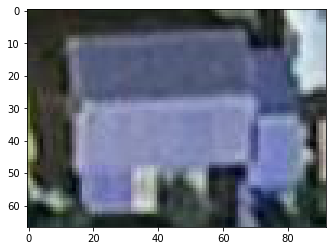

In [4]:
plt.imshow(cv_img[1000])

In [5]:
## Using resized images

In [3]:
import glob
import cv2 as cv

path = glob.glob("E:/alaki/resized/roof_images/*.jpg")
resized_images = []
for img in path:
    n = cv.imread(img)
    resized_images.append(n)

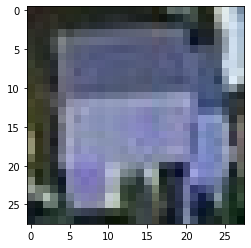

In [7]:
plt.imshow(resized_images[1000])

In [52]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [53]:
import numpy as np
resized_images=np.array(resized_images)


In [54]:
x_train, x_test = train_test_split(resized_images, test_size=0.30)

In [55]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 3))  # adapt this if using `channels_first` image data format

Let's train this model for 50 epochs. For the sake of demonstrating how to visualize the results of a model during training, we will be using the TensorFlow backend and the TensorBoard callback.

First, let's open up a terminal and start a TensorBoard server that will read logs stored at /tmp/autoencoder.

tensorboard --logdir=/tmp/autoencoder



Then let's train our model. In the callbacks list we pass an instance of the TensorBoard callback. After every epoch, this callback will write logs to /tmp/autoencoder, which can be read by our TensorBoard server

In [57]:


autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='\\tmp\\autoencoder')])

Train on 29931 samples, validate on 12828 samples
Epoch 1/50
29931/29931 [==============================] - 82s 3ms/step - loss: 0.6093 - val_loss: 0.6105
Epoch 2/50
29931/29931 [==============================] - 81s 3ms/step - loss: 0.6093 - val_loss: 0.6113
Epoch 3/50
29931/29931 [==============================] - 81s 3ms/step - loss: 0.6091 - val_loss: 0.6079
Epoch 4/50
29931/29931 [==============================] - 81s 3ms/step - loss: 0.6086 - val_loss: 0.6089
Epoch 5/50
29931/29931 [==============================] - 82s 3ms/step - loss: 0.6087 - val_loss: 0.6089
Epoch 6/50
29931/29931 [==============================] - 82s 3ms/step - loss: 0.6088 - val_loss: 0.6096
Epoch 7/50
29931/29931 [==============================] - 81s 3ms/step - loss: 0.6086 - val_loss: 0.6099
Epoch 8/50
29931/29931 [==============================] - 80s 3ms/step - loss: 0.6085 - val_loss: 0.6104
Epoch 9/50
29931/29931 [==============================] - 80s 3ms/step - loss: 0.6087 - val_loss: 0.6099
Epoch

In [59]:
decoded_imgs = autoencoder.predict(x_test)


<Figure size 1440x288 with 0 Axes>

<Figure size 1440x288 with 0 Axes>

<function matplotlib.pyplot.show(*args, **kw)>

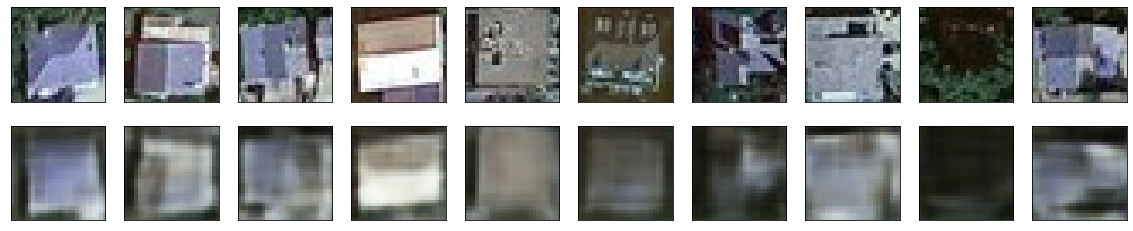

In [60]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show